# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [77]:
# Import numpy and pandas
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [3]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
# Your code here:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# Your code here:
sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attitude.roll       1751 non-null   float64
 1   attitude.pitch      1751 non-null   float64
 2   attitude.yaw        1751 non-null   float64
 3   gravity.x           1751 non-null   float64
 4   gravity.y           1751 non-null   float64
 5   gravity.z           1751 non-null   float64
 6   rotationRate.x      1751 non-null   float64
 7   rotationRate.y      1751 non-null   float64
 8   rotationRate.z      1751 non-null   float64
 9   userAcceleration.x  1751 non-null   float64
 10  userAcceleration.y  1751 non-null   float64
 11  userAcceleration.z  1751 non-null   float64
dtypes: float64(12)
memory usage: 164.3 KB


How many rows and columns are in our data?

In [6]:
# Your code here:
len(sensor.columns)
len(sensor)

1751

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
# Your code here:
c=pd.date_range('1/1/2018 00:00:00','1/1/2018 00:29:10', periods= len(sensor))
freq= pd.infer_freq(c)
c.freq=freq
c

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq='S')

Assign the time series index to the dataframe's index.

In [8]:
# Your code here:
sensor= sensor.set_index(c)
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 



<AxesSubplot:>

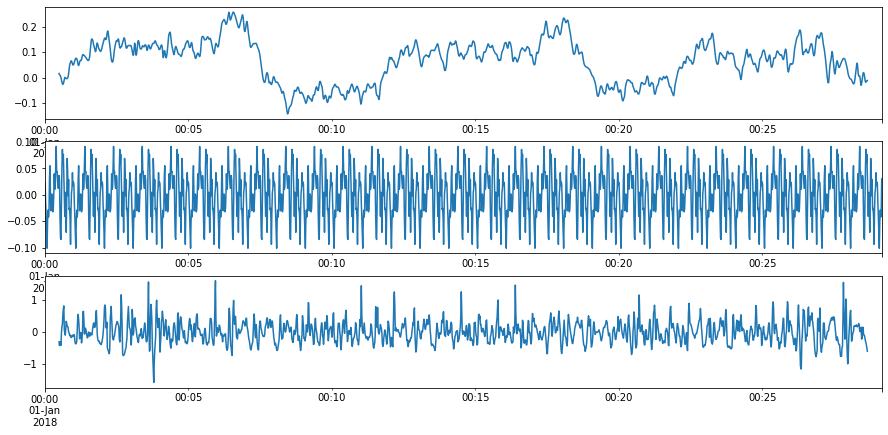

In [23]:
res = seasonal_decompose(sensor['userAcceleration.x'], model="additive", period=60)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,7))
res.trend.plot(ax=ax1)
res.seasonal.plot(ax=ax2)
res.resid.plot(ax=ax3)

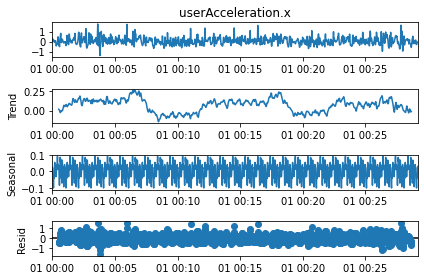

In [22]:
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

<AxesSubplot:>

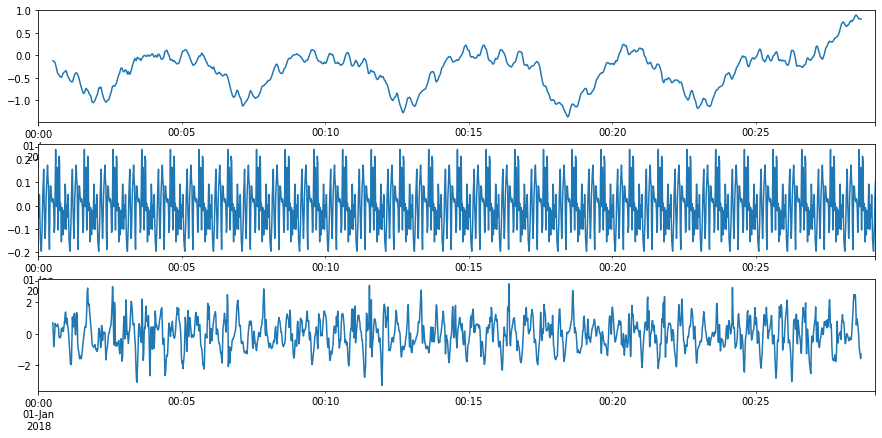

In [26]:
res = seasonal_decompose(sensor['rotationRate.x'], model="additive", period=60)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,7))
res.trend.plot(ax=ax1)
res.seasonal.plot(ax=ax2)
res.resid.plot(ax=ax3)


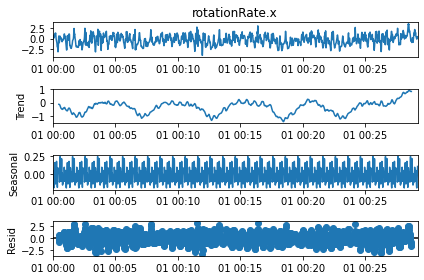

In [27]:
res.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

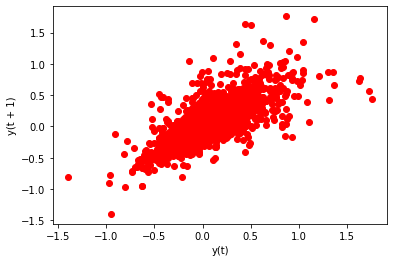

In [46]:
# Your code here:
pd.plotting.lag_plot(sensor['userAcceleration.x'], c='red', alpha=1)

Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

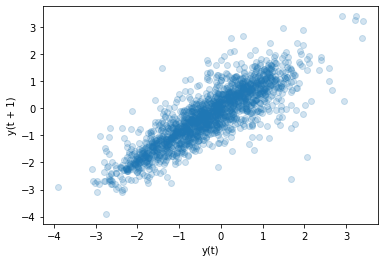

In [45]:
# Your code here:
pd.plotting.lag_plot(sensor['rotationRate.x'], alpha=0.2)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

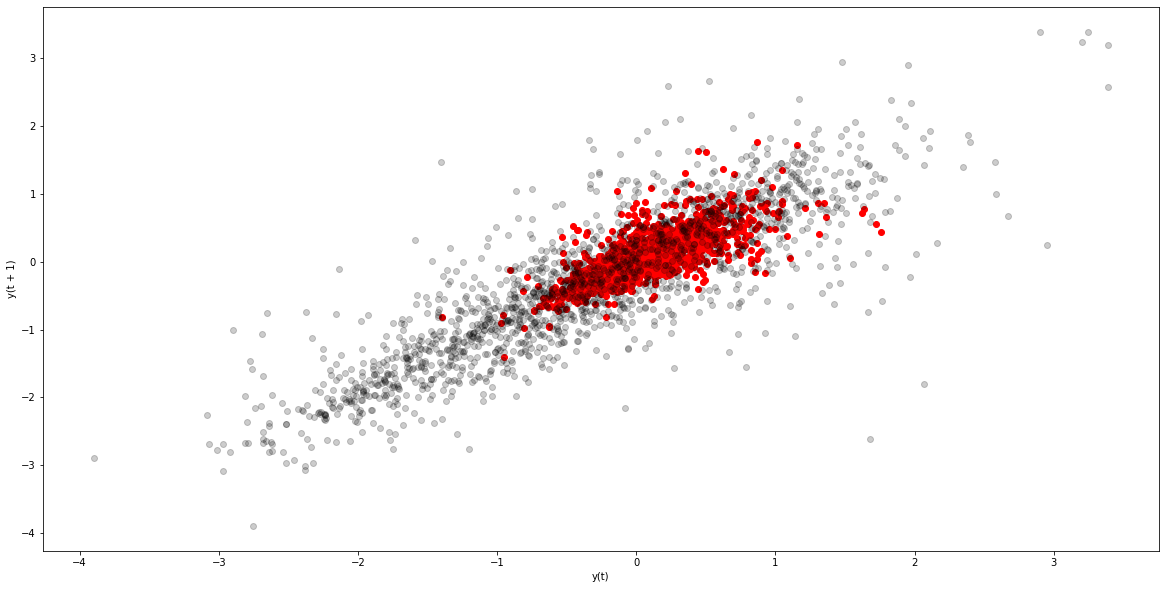

In [47]:
fig, ax1= plt.subplots(figsize=(20,10))

plt.subplot
pd.plotting.lag_plot(sensor['userAcceleration.x'], c='red', alpha=1)

plt.subplot
pd.plotting.lag_plot(sensor['rotationRate.x'], c='black', alpha=0.2)

What are your conclusions from both visualizations?

We can see that in both of the autocorrelation seems to be pretty high, as they go along a diagonal line. It seems to be higher for rotation.



The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

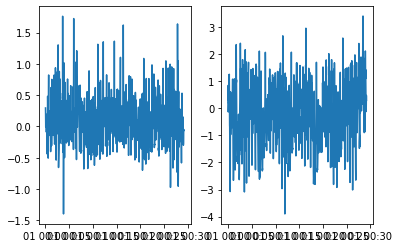

In [70]:
fig, (ax1,ax2) =plt.subplots(1,2)
ax1.plot(sensor['userAcceleration.x'])
ax2.plot(sensor['rotationRate.x']);

Visually, it seems like both of them are stationary, however lets check doing the Dickey  Fuller test.

In [76]:
res1 = adfuller(sensor['userAcceleration.x'])
pvalue1 = res1[1]
res2 = adfuller(sensor['rotationRate.x'])
pvalue2 = res2[1]
print(pvalue1)
print(pvalue2)

2.823439483037483e-30
6.3202303359124956e-06


What are your conclusions from this test?

Such a low value means we must reject the Null Hypothesis, which in this case is that the variable is not stationary, meaning therefore that both variables ARE stationary.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [15]:
#AR=



To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [16]:
# Your code here:

